# 환경 설정

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

# 데이터 로드

In [2]:
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv('../src/merged_data.csv')

# 확인을 위해 상위 몇 줄 출력
df.head()


,KFIGIV,KJMVXE,KSENS,KZRODN,NBANK,NCRODB,NCRSTEP,NZOVLAP,NZON,KXEDYN,...,KSWO275,KSWO276,KSWO277,KSWO278,KSWO279,KSWO280,KSWO319,KSWO320,KFZRUN,label
0,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split

# Label, Feature 분리
X = df.drop(["label", "KCNTOMS"], axis=1)  # X : 예측에 사용할 특성들
y = df["label"]                           # y : 타겟 라벨

# 훈련 데이터와 테스트(평가) 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,   # 예: 20%를 테스트 세트로 할당
    random_state=42, # 재현성을 위한 random_state 고정
    stratify=y       # 클래스 비율 유지를 위한 stratify 사용(분류 문제에서 추천)
)

print("훈련 데이터 크기:", X_train.shape)
print("평가 데이터 크기:", X_test.shape)


훈련 데이터 크기: (163973, 2217)
평가 데이터 크기: (40994, 2217)


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# (추가) y 라벨 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

# 범주형(0/1) Feature와 수치형 Feature 구분
categorical_features = [col for col in X_train.columns if set(X_train[col].unique()) <= {0, 1}]
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# StandardScaler를 이용한 정규화 (수치형 컬럼만)
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])  # 훈련 세트 기준으로 fit

# 실제 변환
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[numerical_features] = scaler.transform(X_train[numerical_features])
X_test_scaled[numerical_features]  = scaler.transform(X_test[numerical_features])

X_train_scaled.head()


,KFIGIV,KJMVXE,KSENS,KZRODN,NBANK,NCRODB,NCRSTEP,NZOVLAP,NZON,KXEDYN,...,KSWO274,KSWO275,KSWO276,KSWO277,KSWO278,KSWO279,KSWO280,KSWO319,KSWO320,KFZRUN
57889,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
4526,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
11725,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24740,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
129851,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from xgboost import XGBClassifier

# XGBoost 분류 모델 정의
params = {
    'tree_method': 'hist',  # 히스토그램 기반 분할
    'device': 'cuda'        # GPU 사용 설정 (GPU가 없으면 CPU로 자동 처리)
}
model = XGBClassifier(**params)

# 모델 훈련
model.fit(X_train_scaled, y_train_encoded)

# 학습 완료 후, 중요 Feature 확인
print("중요도 벡터 길이:", len(model.feature_importances_))

중요도 벡터 길이: 2217


c:\Users\iinmv\anaconda3\envs\nuclear_bootcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:16] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


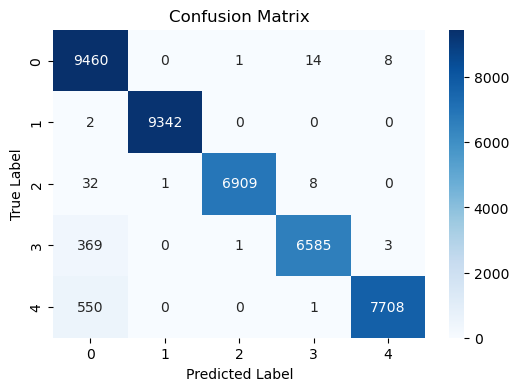

Classification Report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9483
           1       1.00      1.00      1.00      9344
           2       1.00      0.99      1.00      6950
           3       1.00      0.95      0.97      6958
           4       1.00      0.93      0.96      8259

    accuracy                           0.98     40994
   macro avg       0.98      0.97      0.98     40994
weighted avg       0.98      0.98      0.98     40994



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

# 테스트 데이터 예측
# (기존 코드 중 문제 부분만 수정)
y_pred = model.predict(X_test_scaled)  # DMatrix 제거, 그냥 ndarray나 DF 입력

# 혼동 행렬 (Confusion Matrix)
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 정밀도, 재현율, F1, 정확도 등 종합 보고
print("Classification Report")
print(classification_report(y_test_encoded, y_pred))

<Figure size 30000x15000 with 0 Axes>

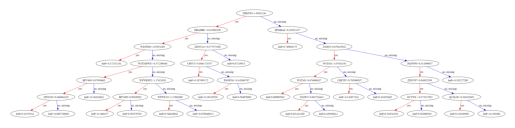

In [12]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# 시각화하고 싶은 트리 인덱스
tree_index = 0

# (1) 그림 객체(figure) 생성 시, figsize & dpi 설정
fig = plt.figure(figsize=(100, 50), dpi=300)  # 가로 60인치, 세로 30인치, 300 DPI

plot_tree(model, num_trees=tree_index)

# (2) 저장 시에도 dpi=300, bbox_inches='tight' 권장
plt.savefig("xgboost_tree1.png", dpi=300, bbox_inches='tight')

# plt.show()로 화면에 표시할 수도 있음
plt.show()


In [13]:
import xgboost as xgb

# 트리 인덱스
tree_index = 0

# (1) Booster 객체 가져오기 (XGBClassifier -> Booster)
booster = model.get_booster()

# (2) to_graphviz: DOT format (문자열) 생성
dot_data = xgb.to_graphviz(booster, num_trees=tree_index)

# (3) .dot 파일로 저장
dot_data.save('xgboost_tree.dot')

# (4) .dot -> png 변환 (graphviz CLI 필요)
dot_data.render('xgboost_tree3', format='png')  # xgboost_tree.png 생성


'xgboost_tree3.png'

In [8]:
import numpy as np

# Feature Importance 계산
feature_importances = model.feature_importances_
features = X_train.columns  # 원본 Feature 이름
importance_df = pd.DataFrame({"feature": features, "importance": feature_importances})

# 중요도를 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by="importance", ascending=False)

# 파일로 저장
output_file = '../src/feature_importances.txt'
importance_df.to_csv(output_file, index=False, sep='\t')

print(f"Feature importance saved to {output_file}")
importance_df.head()


Feature importance saved to ../src/feature_importances.txt


,feature,importance
612,VSUMP,0.225016
135,UFUEL18,0.194568
649,YCVRR,0.165886
715,DSECON,0.118549
297,ZPRZNO,0.101444
